This notebook contains code related to an investigation on mmseqs2's Neff scores.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import torch.nn.functional as F
from af22c import neff
from af22c.mmseqs import mmseqs_neff_from_a3m
from af22c.msa import EncMsa
from af22c.scores import pwseq, identity_seq_weights, henikoff_seq_weights
import matplotlib.pyplot as plt

In [121]:
mmseqs = "/home/johannes/work/MMseqs2/cmake-build-debug/src/mmseqs"
#MSA_PATH = "../data/Q9A7K5.a3m"
MSA_PATH = "/home/johannes/work/MMseqs2/test/mini.a3m"

In [122]:
mmseqs_scores = {
  k: mmseqs_neff_from_a3m(
    MSA_PATH, mmseqs, {"msa2profile": k}
  )
  for k in ["--wg 0", "--wg 1"]
}

In [123]:
msa = EncMsa.from_thing(MSA_PATH)

In [124]:
assert msa.stoi['-'] == 0, "gaptoken must occur at position 0"
M = F.one_hot(msa.data.long(), len(msa.vocab))[:,:,1:]; M.shape

torch.Size([5, 8, 21])

In [125]:
# NB: this is not Heinkoff weighting, but seqid weighting!
w_henikoff = henikoff_seq_weights(msa, flavor="vanilla", verbose=1); w_henikoff

calc weights: 100%|█████████████████████████████| 5/5 [00:00<00:00, 5725.23it/s]


tensor([0.6250, 0.0625, 0.0625, 0.1458, 0.1042])

In [126]:
# NB: this is not Heinkoff weighting, but seqid weighting!
w_mmseqs = henikoff_seq_weights(msa, flavor="mmseqs", verbose=1); w_mmseqs

calc weights: 100%|█████████████████████████████| 5/5 [00:00<00:00, 3806.08it/s]


tensor([0.5868, 0.0697, 0.0697, 0.1577, 0.1161])

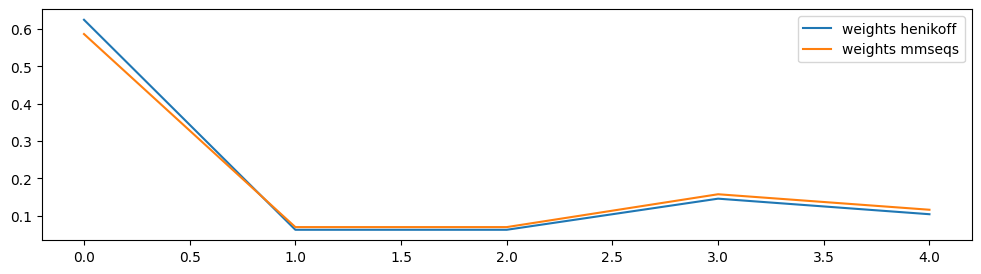

In [127]:
plt.figure(figsize=(12,3))
plt.plot(w_henikoff, label="weights henikoff")
plt.plot(w_mmseqs,label="weights mmseqs")
plt.legend()

In [128]:
f = torch.einsum("i,ijk->jk", w_mmseqs, M.float())

In [129]:
f.shape

torch.Size([8, 21])

In [130]:
# normalized f
nf = f / f.sum(1,keepdim=True)

In [131]:
nonzero_nf = torch.where(nf > 1e-10, nf, 1.) # number taken from mmseqs PSSMCalculator.cpp#546
neff = 2 ** (-(nonzero_nf * nonzero_nf.log2()).mean(1)); neff

tensor([1.0000, 1.0000, 1.0263, 1.0400, 1.0216, 1.0249, 1.0249, 1.0000])

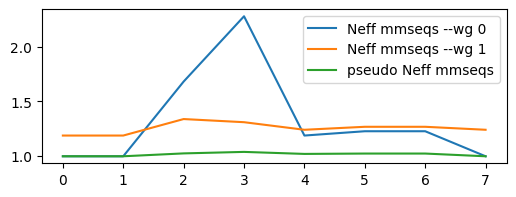

In [207]:
plt.figure(figsize=(6,2))
for k, v in mmseqs_scores.items():
  plt.plot(v,label="Neff mmseqs " + k)
plt.plot(neff,label="pseudo Neff mmseqs")
#plt.plot(10 ** neff,label="10 ** pseudo Neff mmseqs")
plt.legend();

In [133]:
10 - 9 * (2 ** (w_mmseqs[0] * -.08))

tensor(1.2881)

In [136]:
w_mmseqs[0] - 1/5

tensor(0.3868)

In [140]:
msa.data[:,2]

tensor([14, 19,  4, 14,  0], dtype=torch.uint8)

In [149]:
nf[2]

tensor([0.0000, 0.0000, 0.0000, 0.0788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.8423, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0788, 0.0000, 0.0000])

In [150]:
nf[3]

tensor([0.0000, 0.0000, 0.0000, 0.1655, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.1379, 0.0000, 0.0000, 0.0000, 0.0000,
        0.6967, 0.0000, 0.0000])

In [184]:
nonzero_nf = torch.where(nf > 1e-10, nf, torch.tensor(1))

In [186]:
neff_M2 = -(nonzero_nf[2] * nonzero_nf[2].log2()).sum()

In [187]:
neff_M3 = -(nonzero_nf[3] * nonzero_nf[3].log2()).sum()

In [190]:
neff_M2,neff_M3,neff_M2 + neff_M3

(tensor(0.7864), tensor(1.1869), tensor(1.9733))

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000, -3.6649,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.2476,  0.0000,  0.0000,
          0.0000,  0.0000, -3.6649,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000, -2.5955,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -2.8585,  0.0000,  0.0000,
          0.0000,  0.0000, -0.5215,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000, -0.2605,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.000

In [201]:
s = 0
for idx, x in enumerate(list(nf[2]) + list(nf[3])):
  if x > 1e-10:
    s -= x * x.log2()
    print(idx,x,s)

3 tensor(0.0788) tensor(0.2889)
13 tensor(0.8423) tensor(0.4975)
18 tensor(0.0788) tensor(0.7864)
24 tensor(0.1655) tensor(1.2159)
34 tensor(0.1379) tensor(1.6100)
39 tensor(0.6967) tensor(1.9733)


In [205]:
nf[3][18] + nf[3][3]

tensor(0.8621)

In [206]:
nf[3]

tensor([0.0000, 0.0000, 0.0000, 0.1655, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.1379, 0.0000, 0.0000, 0.0000, 0.0000,
        0.6967, 0.0000, 0.0000])

look why our normalized frequencies `nf` are different to mmseqs, especially at position `f[3]`/`nf[3]`.